# Greedy Algorithm Benchmarking (Runtime)

This notebook serves to benchmark VanillaGreedySolver and our various solvers with runtime improvements. However, it will also work with other solvers as well.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/).

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import cassiopeia as cas

## Building benchmarking pipeline

The benchmarking pipeline consists of:

1. Simulating a ground truth phylogeny
2. Overlaying data onto this phylogeny
3. Inferring the phylogeny with potentially many algorithms
4. Assessing performance

Setting up necessary variables
- `algorithm` = The algorithms we will compare
- `bd_sim` = Simulates a birth-death process for creating a ground truth tree
- `lt_sim` = Uses a Cas9-based lineage tracing data simulator for overlaying data

In [2]:
algorithms = {
    "Vanilla": cas.solver.VanillaGreedySolver(),
    "Pandas": cas.solver.PandasGreedySolver(),
    "Multi-Threading": cas.solver.MultiThreadGreedySolver(),
    "Multi-Processing": cas.solver.MultiProcessGreedySolver()
    # can add more algorithms here
}

bd_sim = cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution=lambda scale: np.random.exponential(scale),
    initial_birth_scale=0.5,
    death_waiting_distribution=lambda: np.random.exponential(1.5),
    mutation_distribution=lambda: 1 if np.random.uniform() < 0.5 else 0,
    fitness_distribution=lambda: np.random.normal(0, 0.5),
    fitness_base=1.3,
    num_extant=400,
    random_seed=17,
)

np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes=40,
    size_of_cassette=1,
    mutation_rate=0.1,
    state_generating_distribution=lambda: np.random.exponential(1e-5),
    number_of_states=50,
    state_priors=None,
    heritable_silencing_rate=9e-4,
    stochastic_silencing_rate=0.1,
    heritable_missing_data_state=-1,
    stochastic_missing_data_state=-1,
)

In [3]:
# Main Benchmark Code
iterations = 10
algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)

for _ in tqdm(range(iterations)):
    ground_truth_tree = bd_sim.simulate_tree()

    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)

    for algorithm_name in tqdm(algorithms.keys()):
        algorithm = algorithms[algorithm_name]
        reconstructed_tree = cas.data.CassiopeiaTree(
            character_matrix=ground_truth_tree.character_matrix,
            missing_state_indicator=-1,
        )
        algorithm.solve(reconstructed_tree)
        
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters=True)

        rf, rf_max = cas.critique.compare.robinson_foulds(
            ground_truth_tree, reconstructed_tree
        )

        triplets = cas.critique.compare.triplets_correct(
            ground_truth_tree, reconstructed_tree, number_of_trials=500
        )
        algorithm_to_performance_triplets[algorithm_name].append(
            np.mean(list(triplets[0].values()))
        )

        algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

**Visualising Results**

We will visualize the results by looking at two metrics offered by the Cassiopeia `critique` library:

- Triplets Correct Measure
- Robinson-Foulds Distance

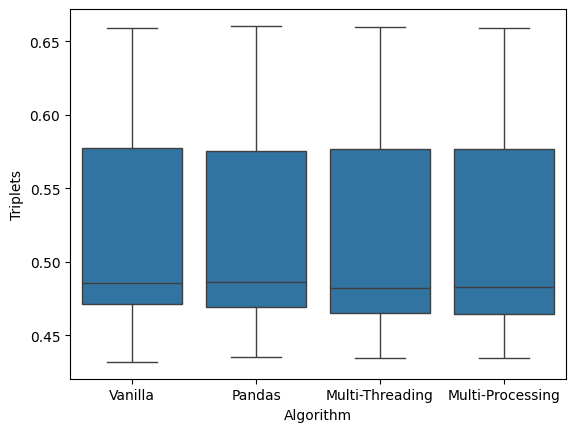

                  count      mean       std       min       25%       50%  \
Algorithm                                                                   
Multi-Processing   10.0  0.515911  0.075541  0.434222  0.464556  0.483056   
Multi-Threading    10.0  0.516222  0.076081  0.434667  0.464833  0.481833   
Pandas             10.0  0.517233  0.074432  0.435444  0.469444  0.486444   
Vanilla            10.0  0.516189  0.075725  0.431778  0.471083  0.485389   

                       75%       max  
Algorithm                             
Multi-Processing  0.576972  0.659111  
Multi-Threading   0.576639  0.659889  
Pandas            0.575472  0.660444  
Vanilla           0.577250  0.658889  


In [6]:
# Triplets Correct Measure
algorithm_to_performance_triplets_df = pd.DataFrame(columns=["Algorithm", "Triplets"])
for algorithm in algorithm_to_performance_triplets:
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["Triplets"] = entries

    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])

sns.boxplot(data=algorithm_to_performance_triplets_df, x="Algorithm", y="Triplets")
plt.show()

triplets_stats = algorithm_to_performance_triplets_df.groupby("Algorithm")["Triplets"].describe()
print(triplets_stats)

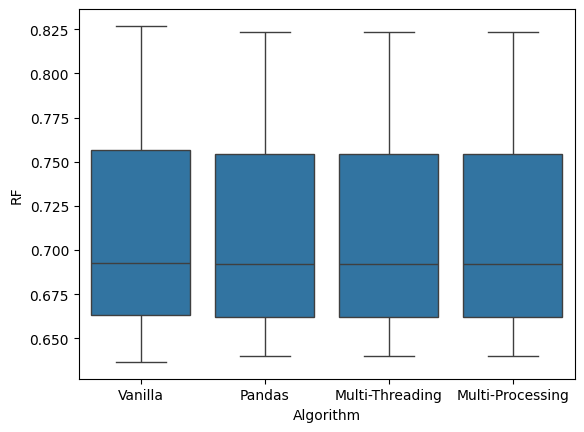

                  count      mean       std       min       25%       50%  \
Algorithm                                                                   
Multi-Processing   10.0  0.707528  0.061162  0.639794  0.662341  0.692290   
Multi-Threading    10.0  0.707528  0.061162  0.639794  0.662341  0.692290   
Pandas             10.0  0.707528  0.061162  0.639794  0.662341  0.692290   
Vanilla            10.0  0.708310  0.062419  0.636678  0.663449  0.692547   

                       75%       max  
Algorithm                             
Multi-Processing  0.754082  0.823322  
Multi-Threading   0.754082  0.823322  
Pandas            0.754082  0.823322  
Vanilla           0.756347  0.826855  


In [7]:
# Robinson-Foulds Distance
algorithm_to_performance_rf_df = pd.DataFrame(columns=["Algorithm", "RF"])
for algorithm in algorithm_to_performance_rf:
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm] * len(entries), columns=["Algorithm"])
    new_df["RF"] = entries

    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

sns.boxplot(data=algorithm_to_performance_rf_df, x="Algorithm", y="RF")
plt.show()

rf_stats = algorithm_to_performance_rf_df.groupby("Algorithm")["RF"].describe()
print(rf_stats)